




<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## Imports

In [1]:
import numpy as np
import pandas as pd
from packaging import version

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab Environment

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

## EDA Functions

In [6]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [7]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [8]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [9]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [12]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [13]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [14]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [15]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

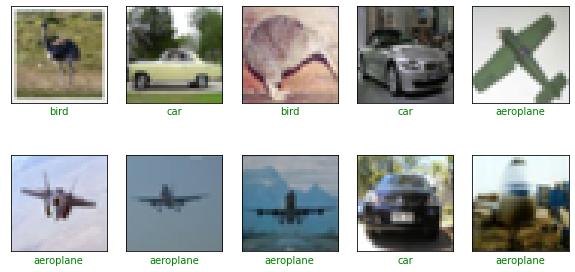

In [16]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [17]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [7]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [17]:
y_train_split.shape

(45000, 1)

## Confirm Datasets {Train, Validation, Test}

In [19]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [12]:
x_train_split.shape

(45000, 32, 32, 3)

## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [15]:
x_train_split[0]#[0].shape

array([[[ 18,  12,  24],
        [ 22,  16,  28],
        [ 27,  21,  33],
        ...,
        [ 26,  19,  30],
        [ 14,  11,  18],
        [ 11,  10,  16]],

       [[ 18,  12,  24],
        [ 21,  15,  27],
        [ 25,  19,  31],
        ...,
        [ 27,  23,  32],
        [ 21,  21,  27],
        [ 17,  18,  24]],

       [[ 23,  17,  29],
        [ 22,  16,  28],
        [ 20,  14,  26],
        ...,
        [ 29,  28,  37],
        [ 25,  26,  32],
        [ 21,  25,  30]],

       ...,

       [[ 44,  24,  35],
        [ 48,  26,  38],
        [ 55,  31,  43],
        ...,
        [130, 131, 159],
        [105, 104, 127],
        [ 65,  60,  82]],

       [[ 25,  17,  27],
        [ 29,  21,  31],
        [ 38,  28,  38],
        ...,
        [125, 127, 155],
        [ 91,  89, 113],
        [ 49,  42,  64]],

       [[ 16,  13,  20],
        [ 19,  16,  24],
        [ 22,  18,  27],
        ...,
        [101, 100, 125],
        [ 55,  51,  72],
        [ 26,  19,  37]]

In [20]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

In [21]:
x_train_norm.shape

(45000, 32, 32, 3)

# DNN

In [22]:
from keras.utils.vis_utils import plot_model

In [23]:
DNN_X_train = x_train_norm.reshape(x_train_norm.shape[0], 3072) # 32*32*3
DNN_X_valid = x_valid_norm.reshape(x_valid_norm.shape[0], 3072)
DNN_X_test = x_test_norm.reshape(x_test_norm.shape[0], 3072)

# EXP-1 DNN

In [24]:
keras.backend.clear_session()
model1 = Sequential()
model1.add(Dense(200, activation='relu', input_shape=[3072]))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(10, activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               614600    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 635,710
Trainable params: 635,710
Non-trainable params: 0
_________________________________________________________________


In [25]:
model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [26]:
%%time

history1 = model1.fit(DNN_X_train, y_train_split, batch_size=100,
                    validation_data=(DNN_X_valid, y_valid_split), 
                    epochs=20, verbose=1,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model_exp1.h5",save_best_only=True,save_weights_only=False)
                    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] )

Epoch 1/20
450/450 [==============================] - 3s 4ms/step - loss: 1.9029 - accuracy: 0.3197 - val_loss: 1.7597 - val_accuracy: 0.3736
Epoch 2/20
450/450 [==============================] - 2s 5ms/step - loss: 1.7094 - accuracy: 0.3906 - val_loss: 1.6946 - val_accuracy: 0.3916
Epoch 3/20
450/450 [==============================] - 2s 5ms/step - loss: 1.6290 - accuracy: 0.4198 - val_loss: 1.6372 - val_accuracy: 0.4086
Epoch 4/20
450/450 [==============================] - 2s 5ms/step - loss: 1.5765 - accuracy: 0.4406 - val_loss: 1.6593 - val_accuracy: 0.4190
Epoch 5/20
450/450 [==============================] - 2s 5ms/step - loss: 1.5353 - accuracy: 0.4526 - val_loss: 1.5568 - val_accuracy: 0.4476
Epoch 6/20
450/450 [==============================] - 3s 7ms/step - loss: 1.5039 - accuracy: 0.4640 - val_loss: 1.5449 - val_accuracy: 0.4420
Epoch 7/20
450/450 [==============================] - 3s 6ms/step - loss: 1.4788 - accuracy: 0.4739 - val_loss: 1.5705 - val_accuracy: 0.4342
CPU ti

In [27]:
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
history_df=pd.DataFrame(history_dict)
history_df.columns = ['Training_loss','Train_acc','Validation_loss','Validation_acc']
history_df.tail().round(3)

,Training_loss,Train_acc,Validation_loss,Validation_acc
2,1.629,0.420,1.637,0.409
3,1.576,0.441,1.659,0.419
4,1.535,0.453,1.557,0.448
5,1.504,0.464,1.545,0.442
6,1.479,0.474,1.571,0.434


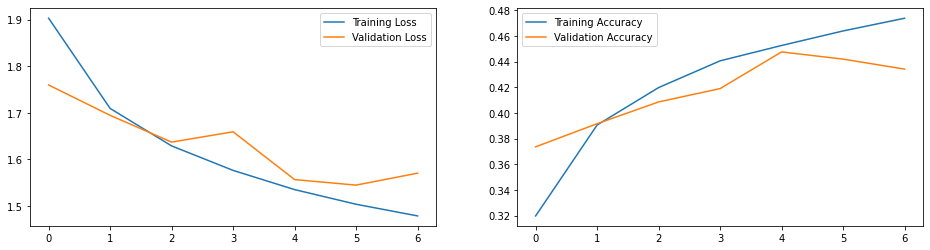

In [29]:
plot_history(history1)

313/313 [==============================] - 1s 4ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.42      0.50      1000
           1       0.57      0.58      0.58      1000
           2       0.41      0.07      0.13      1000
           3       0.29      0.42      0.35      1000
           4       0.46      0.33      0.38      1000
           5       0.40      0.32      0.35      1000
           6       0.38      0.71      0.49      1000
           7       0.58      0.46      0.51      1000
           8       0.51      0.72      0.60      1000
           9       0.50      0.55      0.52      1000

    accuracy                           0.46     10000
   macro avg       0.47      0.46      0.44     10000
weighted avg       0.47      0.46      0.44     10000

Accuracy Score: 0.4577
Root Mean Square Error: 3.1966232183352483


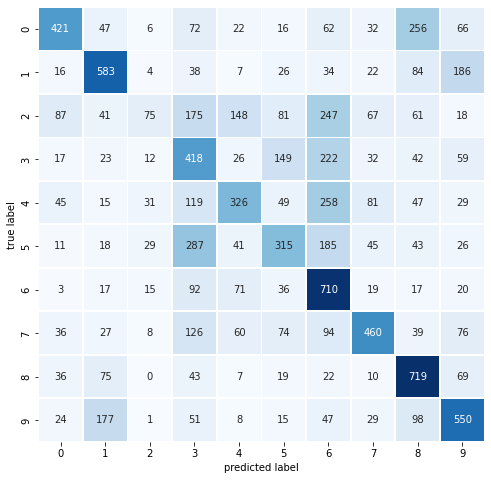

In [30]:
pred1= model1.predict(DNN_X_test)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)
plot_confusion_matrix(y_test,pred1)

# EXP-2 DNN

In [31]:
keras.backend.clear_session()
model2 = Sequential()
model2.add(Dense(200, activation='relu', input_shape=[3072]))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(10, activation='softmax'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               614600    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 645,810
Trainable params: 645,810
Non-trainable params: 0
_________________________________________________________________


In [32]:
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [33]:
%%time
history2 = model2.fit(DNN_X_train, y_train_split, batch_size=100,
                    validation_data=(DNN_X_valid, y_valid_split), 
                    epochs=20, verbose=1,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model_exp2.h5",save_best_only=True,save_weights_only=False)
                    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] )

Epoch 1/20
450/450 [==============================] - 5s 8ms/step - loss: 1.8993 - accuracy: 0.3124 - val_loss: 1.7726 - val_accuracy: 0.3558
Epoch 2/20
450/450 [==============================] - 3s 6ms/step - loss: 1.7079 - accuracy: 0.3873 - val_loss: 1.6914 - val_accuracy: 0.3876
Epoch 3/20
450/450 [==============================] - 2s 4ms/step - loss: 1.6364 - accuracy: 0.4145 - val_loss: 1.6248 - val_accuracy: 0.4128
Epoch 4/20
450/450 [==============================] - 1s 3ms/step - loss: 1.5670 - accuracy: 0.4396 - val_loss: 1.5832 - val_accuracy: 0.4264
Epoch 5/20
450/450 [==============================] - 1s 3ms/step - loss: 1.5218 - accuracy: 0.4579 - val_loss: 1.5811 - val_accuracy: 0.4284
Epoch 6/20
450/450 [==============================] - 1s 3ms/step - loss: 1.4957 - accuracy: 0.4660 - val_loss: 1.5437 - val_accuracy: 0.4464
Epoch 7/20
450/450 [==============================] - 1s 3ms/step - loss: 1.4602 - accuracy: 0.4807 - val_loss: 1.5295 - val_accuracy: 0.4574
Epoch 

In [34]:
history_dict = history2.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history_df=pd.DataFrame(history_dict)
history_df.columns = ['Training_loss','Train_acc','Validation_loss','Validation_acc']
history_df.tail().round(3)

,Training_loss,Train_acc,Validation_loss,Validation_acc
10,1.377,0.511,1.460,0.472
11,1.352,0.517,1.495,0.465
12,1.340,0.523,1.466,0.480
13,1.320,0.528,1.482,0.473
14,1.312,0.533,1.468,0.476


In [36]:
history2.on_batch_begin

<bound method Callback.on_batch_begin of <keras.callbacks.History object at 0x7f78f014de90>>

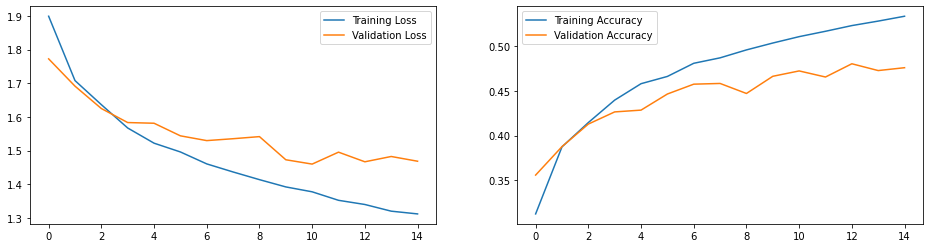

In [37]:
plot_history(history2)

313/313 [==============================] - 1s 4ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.52      0.56      1000
           1       0.66      0.55      0.60      1000
           2       0.35      0.37      0.36      1000
           3       0.32      0.32      0.32      1000
           4       0.45      0.41      0.43      1000
           5       0.42      0.40      0.41      1000
           6       0.52      0.54      0.53      1000
           7       0.45      0.68      0.54      1000
           8       0.65      0.59      0.62      1000
           9       0.57      0.53      0.55      1000

    accuracy                           0.49     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       0.50      0.49      0.49     10000

Accuracy Score: 0.4912
Root Mean Square Error: 3.0139177161959814


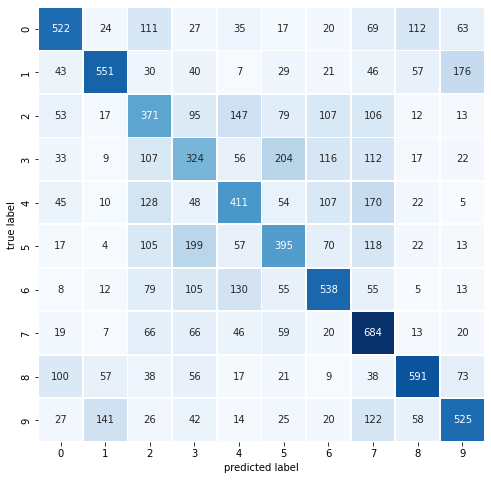

In [38]:
pred1= model2.predict(DNN_X_test)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)
plot_confusion_matrix(y_test,pred1)

# CNN

# EXP-3

In [39]:
model3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [40]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 384)              

In [41]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [42]:
%%time
history3 = model3.fit(x_train_norm
                    ,y_train_split
                    ,epochs= 5
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/5
450/450 [==============================] - 8s 14ms/step - loss: 2.1499 - accuracy: 0.2434 - val_loss: 2.0366 - val_accuracy: 0.2896
Epoch 2/5
450/450 [==============================] - 7s 16ms/step - loss: 1.9325 - accuracy: 0.2931 - val_loss: 1.8454 - val_accuracy: 0.3014
Epoch 3/5
450/450 [==============================] - 7s 15ms/step - loss: 1.7839 - accuracy: 0.3226 - val_loss: 1.7131 - val_accuracy: 0.3358
Epoch 4/5
450/450 [==============================] - 7s 15ms/step - loss: 1.6539 - accuracy: 0.3476 - val_loss: 1.6220 - val_accuracy: 0.3410
Epoch 5/5
450/450 [==============================] - 6s 14ms/step - loss: 1.5645 - accuracy: 0.3616 - val_loss: 1.5568 - val_accuracy: 0.3580
CPU times: user 33.4 s, sys: 1.74 s, total: 35.1 s
Wall time: 43.6 s


In [43]:
history_dict = history3.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [44]:
history_dict

{'loss': [2.1499364376068115,
  1.9325071573257446,
  1.783941626548767,
  1.653928279876709,
  1.5644919872283936],
 'accuracy': [0.2433999925851822,
  0.29306668043136597,
  0.32264444231987,
  0.3476444482803345,
  0.3615555465221405],
 'val_loss': [2.0366055965423584,
  1.8454097509384155,
  1.7131404876708984,
  1.6220186948776245,
  1.5567970275878906],
 'val_accuracy': [0.2896000146865845,
  0.30140000581741333,
  0.3357999920845032,
  0.3409999907016754,
  0.3580000102519989]}

In [45]:
history_df=pd.DataFrame(history_dict)
history_df.columns = ['Training_loss','Train_acc','Validation_loss','Validation_acc']
history_df.tail().round(3)

,Training_loss,Train_acc,Validation_loss,Validation_acc
0,2.150,0.243,2.037,0.290
1,1.933,0.293,1.845,0.301
2,1.784,0.323,1.713,0.336
3,1.654,0.348,1.622,0.341
4,1.564,0.362,1.557,0.358


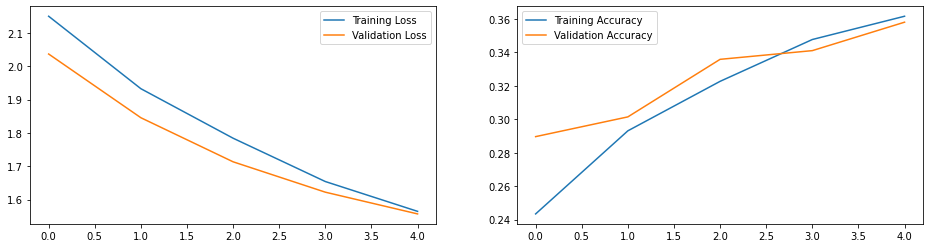

In [46]:
plot_history(history3)

313/313 [==============================] - 1s 3ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.33      0.08      0.13      1000
           1       0.49      0.76      0.60      1000
           2       0.26      0.05      0.08      1000
           3       0.24      0.04      0.06      1000
           4       0.25      0.14      0.18      1000
           5       0.17      0.10      0.12      1000
           6       0.29      0.82      0.43      1000
           7       0.40      0.78      0.53      1000
           8       0.44      0.81      0.57      1000
           9       0.41      0.07      0.13      1000

    accuracy                           0.36     10000
   macro avg       0.33      0.36      0.28     10000
weighted avg       0.33      0.36      0.28     10000

Accuracy Score: 0.3644
Root Mean Square Error: 3.878440408205339


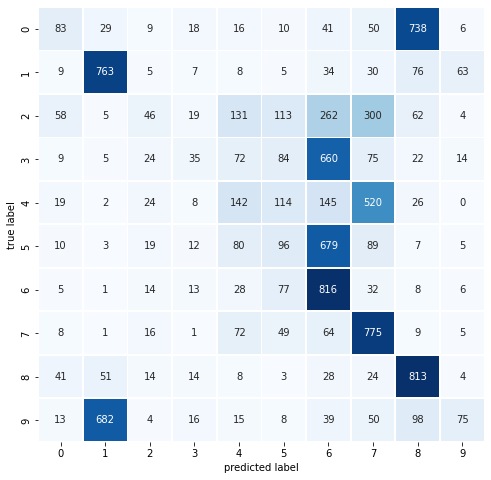

In [47]:
pred1= model3.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)
plot_confusion_matrix(y_test,pred1)

# EXP-4

In [48]:
model = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
    
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax),
  Dense(units=10, activation=tf.nn.softmax)       
])

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 512)       

In [50]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [51]:
%%time
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs= 5
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/5
450/450 [==============================] - 8s 17ms/step - loss: 2.1843 - accuracy: 0.1868 - val_loss: 2.0749 - val_accuracy: 0.2060
Epoch 2/5
450/450 [==============================] - 7s 16ms/step - loss: 2.0156 - accuracy: 0.2318 - val_loss: 1.9319 - val_accuracy: 0.2750
Epoch 3/5
450/450 [==============================] - 8s 17ms/step - loss: 1.8674 - accuracy: 0.3033 - val_loss: 1.8208 - val_accuracy: 0.3250
Epoch 4/5
450/450 [==============================] - 7s 17ms/step - loss: 1.7304 - accuracy: 0.3450 - val_loss: 1.6883 - val_accuracy: 0.3376
Epoch 5/5
450/450 [==============================] - 8s 17ms/step - loss: 1.6058 - accuracy: 0.3736 - val_loss: 1.5974 - val_accuracy: 0.3598
CPU times: user 38.2 s, sys: 1.19 s, total: 39.3 s
Wall time: 42.1 s


In [52]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
history_df=pd.DataFrame(history_dict)
history_df.columns = ['Training_loss','Train_acc','Validation_loss','Validation_acc']
history_df.tail().round(3)

,Training_loss,Train_acc,Validation_loss,Validation_acc
0,2.184,0.187,2.075,0.206
1,2.016,0.232,1.932,0.275
2,1.867,0.303,1.821,0.325
3,1.730,0.345,1.688,0.338
4,1.606,0.374,1.597,0.360


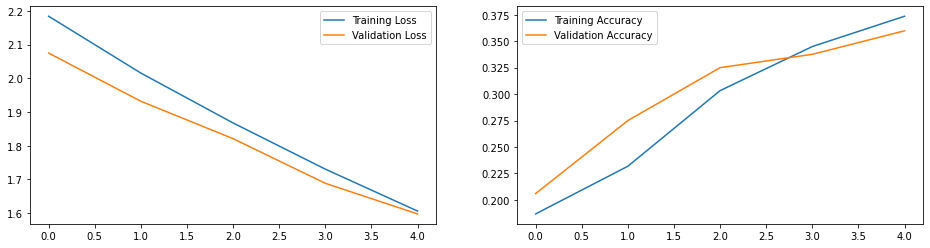

In [54]:
plot_history(history)

313/313 [==============================] - 1s 3ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.43      0.73      0.55      1000
           1       0.47      0.80      0.59      1000
           2       0.29      0.12      0.17      1000
           3       0.20      0.06      0.09      1000
           4       0.29      0.06      0.10      1000
           5       0.19      0.05      0.08      1000
           6       0.24      0.93      0.38      1000
           7       0.62      0.73      0.67      1000
           8       0.41      0.08      0.14      1000
           9       0.46      0.07      0.13      1000

    accuracy                           0.36     10000
   macro avg       0.36      0.36      0.29     10000
weighted avg       0.36      0.36      0.29     10000

Accuracy Score: 0.3638
Root Mean Square Error: 3.8069672969438546


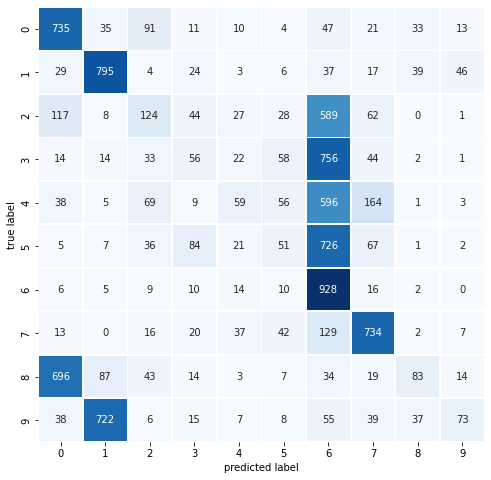

In [55]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)
plot_confusion_matrix(y_test,pred1)

# EXP-5

- EXP-1 redo

In [56]:
keras.backend.clear_session()
model1 = Sequential()
model1.add(Dense(200, activation='relu', input_shape=[3072],kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model1.add(Dense(100, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model1.add(Dense(10, activation='softmax'))
model1.summary()

model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               614600    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 635,710
Trainable params: 635,710
Non-trainable params: 0
_________________________________________________________________


In [57]:
%%time
history1 = model1.fit(DNN_X_train, y_train_split, batch_size=100,
                    validation_data=(DNN_X_valid, y_valid_split), 
                    epochs=20, verbose=1,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model_exp1.h5",save_best_only=True,save_weights_only=False)
                    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] )


Epoch 1/20
450/450 [==============================] - 2s 4ms/step - loss: 2.1717 - accuracy: 0.3097 - val_loss: 1.9633 - val_accuracy: 0.3322
Epoch 2/20
450/450 [==============================] - 1s 3ms/step - loss: 1.8672 - accuracy: 0.3778 - val_loss: 1.8532 - val_accuracy: 0.3796
Epoch 3/20
450/450 [==============================] - 2s 3ms/step - loss: 1.7676 - accuracy: 0.4063 - val_loss: 1.7510 - val_accuracy: 0.4008
Epoch 4/20
450/450 [==============================] - 2s 3ms/step - loss: 1.7216 - accuracy: 0.4229 - val_loss: 1.7350 - val_accuracy: 0.4162
Epoch 5/20
450/450 [==============================] - 1s 3ms/step - loss: 1.6814 - accuracy: 0.4379 - val_loss: 1.6918 - val_accuracy: 0.4284
Epoch 6/20
450/450 [==============================] - 1s 3ms/step - loss: 1.6452 - accuracy: 0.4497 - val_loss: 1.6916 - val_accuracy: 0.4220
Epoch 7/20
450/450 [==============================] - 2s 3ms/step - loss: 1.6351 - accuracy: 0.4524 - val_loss: 1.6590 - val_accuracy: 0.4356
Epoch 

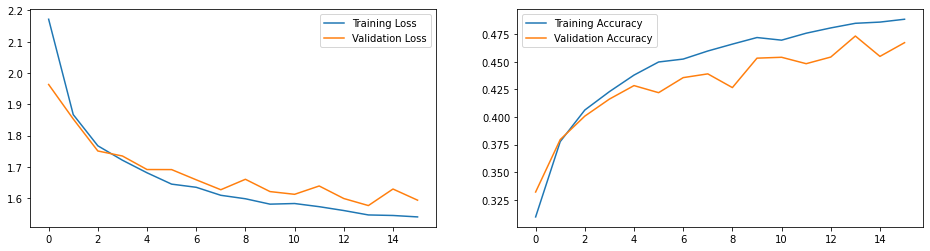

313/313 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.48      0.61      0.54      1000
           1       0.67      0.49      0.57      1000
           2       0.34      0.43      0.38      1000
           3       0.38      0.25      0.30      1000
           4       0.44      0.41      0.42      1000
           5       0.49      0.33      0.39      1000
           6       0.50      0.59      0.54      1000
           7       0.46      0.63      0.53      1000
           8       0.65      0.54      0.59      1000
           9       0.53      0.56      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.48     10000
weighted avg       0.49      0.48      0.48     10000

Accuracy Score: 0.4837
Root Mean Square Error: 3.1750905498898767


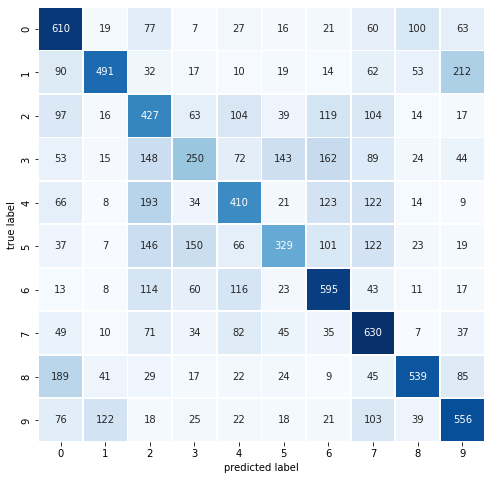

In [58]:
history_dict = history1.history
history_dict.keys()

history_df=pd.DataFrame(history_dict)
history_df.columns = ['Training_loss','Train_acc','Validation_loss','Validation_acc']
history_df.tail().round(3)

plot_history(history1)

pred1= model1.predict(DNN_X_test)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)
plot_confusion_matrix(y_test,pred1)

- EXP-2 Redo

In [59]:
keras.backend.clear_session()
model2 = Sequential()
model2.add(Dense(200, activation='relu', input_shape=[3072],kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model2.add(Dense(100, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model2.add(Dense(100, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model2.add(Dense(10, activation='softmax'))
model2.summary()

model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               614600    
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 645,810
Trainable params: 645,810
Non-trainable params: 0
_________________________________________________________________


In [60]:

%%time
history2 = model2.fit(DNN_X_train, y_train_split, batch_size=100,
                    validation_data=(DNN_X_valid, y_valid_split), 
                    epochs=20, verbose=1,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint("DNN_model_exp2.h5",save_best_only=True,save_weights_only=False)
                    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] )


Epoch 1/20
450/450 [==============================] - 2s 4ms/step - loss: 2.1706 - accuracy: 0.3124 - val_loss: 1.9323 - val_accuracy: 0.3562
Epoch 2/20
450/450 [==============================] - 1s 3ms/step - loss: 1.8570 - accuracy: 0.3809 - val_loss: 1.7938 - val_accuracy: 0.4018
Epoch 3/20
450/450 [==============================] - 2s 3ms/step - loss: 1.7611 - accuracy: 0.4092 - val_loss: 1.7504 - val_accuracy: 0.4082
Epoch 4/20
450/450 [==============================] - 2s 3ms/step - loss: 1.7081 - accuracy: 0.4306 - val_loss: 1.7460 - val_accuracy: 0.4160
Epoch 5/20
450/450 [==============================] - 2s 3ms/step - loss: 1.6760 - accuracy: 0.4392 - val_loss: 1.7060 - val_accuracy: 0.4220
Epoch 6/20
450/450 [==============================] - 1s 3ms/step - loss: 1.6523 - accuracy: 0.4473 - val_loss: 1.7872 - val_accuracy: 0.3938
Epoch 7/20
450/450 [==============================] - 2s 4ms/step - loss: 1.6374 - accuracy: 0.4561 - val_loss: 1.6677 - val_accuracy: 0.4318
Epoch 

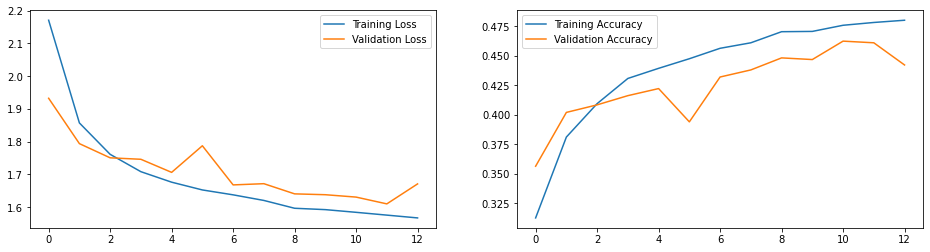

313/313 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.58      0.47      0.52      1000
           1       0.58      0.64      0.61      1000
           2       0.33      0.41      0.37      1000
           3       0.31      0.38      0.34      1000
           4       0.41      0.31      0.35      1000
           5       0.43      0.33      0.37      1000
           6       0.37      0.68      0.48      1000
           7       0.77      0.29      0.42      1000
           8       0.55      0.69      0.61      1000
           9       0.61      0.39      0.47      1000

    accuracy                           0.46     10000
   macro avg       0.49      0.46      0.45     10000
weighted avg       0.49      0.46      0.45     10000

Accuracy Score: 0.4585
Root Mean Square Error: 3.1282423179798586


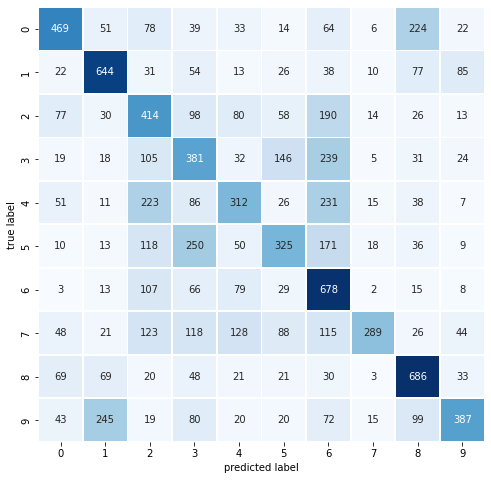

In [61]:
history_dict = history2.history
history_dict.keys()

history_df=pd.DataFrame(history_dict)
history_df.columns = ['Training_loss','Train_acc','Validation_loss','Validation_acc']
history_df.tail().round(3)

plot_history(history2)

pred1= model2.predict(DNN_X_test)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)
plot_confusion_matrix(y_test,pred1)

- EXP-3 redo

In [62]:
model = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  Dense(units=10, activation=tf.nn.softmax)       
])

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense_4 (Dense)             (None, 384)              

In [63]:

%%time
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=20
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )


Epoch 1/20
450/450 [==============================] - 7s 15ms/step - loss: 2.1910 - accuracy: 0.1950 - val_loss: 2.0535 - val_accuracy: 0.2428
Epoch 2/20
450/450 [==============================] - 6s 14ms/step - loss: 2.0032 - accuracy: 0.2348 - val_loss: 1.9310 - val_accuracy: 0.2550
Epoch 3/20
450/450 [==============================] - 6s 14ms/step - loss: 1.9051 - accuracy: 0.2560 - val_loss: 1.8446 - val_accuracy: 0.2748
Epoch 4/20
450/450 [==============================] - 6s 14ms/step - loss: 1.8136 - accuracy: 0.3045 - val_loss: 1.8296 - val_accuracy: 0.3066
Epoch 5/20
450/450 [==============================] - 6s 14ms/step - loss: 1.7020 - accuracy: 0.3516 - val_loss: 1.6611 - val_accuracy: 0.3424
Epoch 6/20
450/450 [==============================] - 6s 14ms/step - loss: 1.6173 - accuracy: 0.3685 - val_loss: 1.5930 - val_accuracy: 0.3594
Epoch 7/20
450/450 [==============================] - 6s 14ms/step - loss: 1.5500 - accuracy: 0.3826 - val_loss: 1.5566 - val_accuracy: 0.3724

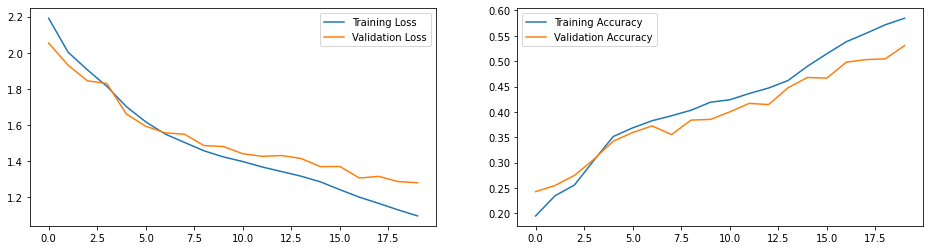

313/313 [==============================] - 1s 2ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.49      0.61      0.54      1000
           1       0.53      0.77      0.63      1000
           2       0.39      0.21      0.28      1000
           3       0.53      0.41      0.46      1000
           4       0.38      0.40      0.39      1000
           5       0.59      0.50      0.54      1000
           6       0.54      0.84      0.66      1000
           7       0.66      0.77      0.71      1000
           8       0.52      0.48      0.50      1000
           9       0.41      0.19      0.26      1000

    accuracy                           0.52     10000
   macro avg       0.51      0.52      0.50     10000
weighted avg       0.51      0.52      0.50     10000

Accuracy Score: 0.5186
Root Mean Square Error: 3.545250343769816


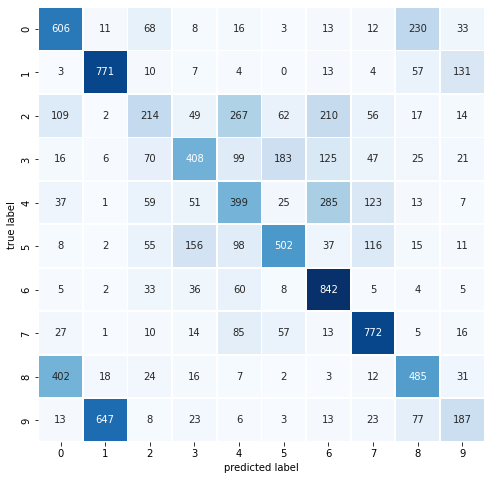

In [64]:
history_dict = history.history
history_dict.keys()

history_df=pd.DataFrame(history_dict)
history_df.columns = ['Training_loss','Train_acc','Validation_loss','Validation_acc']
history_df.tail().round(3)
plot_history(history)

pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)
plot_confusion_matrix(y_test,pred1)

- EXP-4 redo

In [65]:
model = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
    
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  Dense(units=10, activation=tf.nn.softmax)       
])

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 512)       

In [66]:


%%time
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=20
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )



Epoch 1/20
450/450 [==============================] - 8s 17ms/step - loss: 2.2573 - accuracy: 0.1500 - val_loss: 2.1186 - val_accuracy: 0.1828
Epoch 2/20
450/450 [==============================] - 7s 16ms/step - loss: 2.0550 - accuracy: 0.1945 - val_loss: 2.0301 - val_accuracy: 0.1914
Epoch 3/20
450/450 [==============================] - 7s 16ms/step - loss: 1.9619 - accuracy: 0.2242 - val_loss: 1.9297 - val_accuracy: 0.2402
Epoch 4/20
450/450 [==============================] - 7s 16ms/step - loss: 1.8826 - accuracy: 0.2661 - val_loss: 1.8541 - val_accuracy: 0.2728
Epoch 5/20
450/450 [==============================] - 7s 16ms/step - loss: 1.7995 - accuracy: 0.3155 - val_loss: 1.7625 - val_accuracy: 0.3526
Epoch 6/20
450/450 [==============================] - 7s 16ms/step - loss: 1.6879 - accuracy: 0.3869 - val_loss: 1.6456 - val_accuracy: 0.4074
Epoch 7/20
450/450 [==============================] - 7s 17ms/step - loss: 1.5822 - accuracy: 0.4341 - val_loss: 1.5420 - val_accuracy: 0.4412

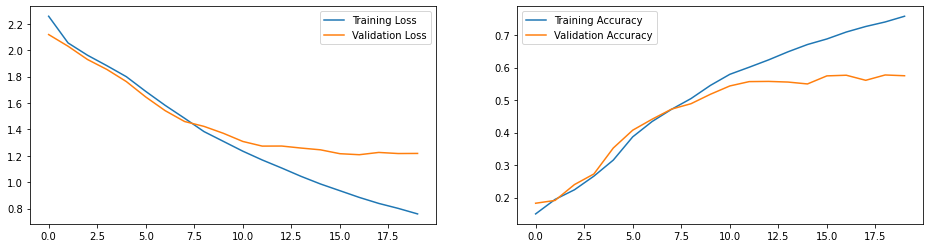

313/313 [==============================] - 1s 3ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.64      0.69      0.67      1000
           1       0.66      0.82      0.73      1000
           2       0.45      0.37      0.41      1000
           3       0.35      0.24      0.28      1000
           4       0.43      0.32      0.37      1000
           5       0.49      0.71      0.58      1000
           6       0.74      0.75      0.74      1000
           7       0.53      0.75      0.62      1000
           8       0.69      0.56      0.62      1000
           9       0.76      0.56      0.64      1000

    accuracy                           0.58     10000
   macro avg       0.57      0.58      0.57     10000
weighted avg       0.57      0.58      0.57     10000

Accuracy Score: 0.5774
Root Mean Square Error: 2.82856854256707


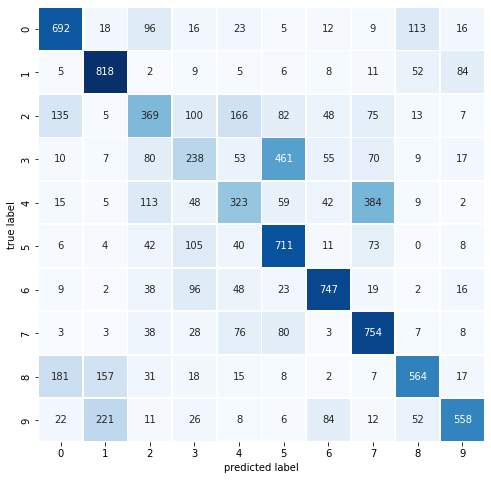

In [67]:
history_dict = history.history
history_dict.keys()

history_df=pd.DataFrame(history_dict)
history_df.columns = ['Training_loss','Train_acc','Validation_loss','Validation_acc']
history_df.tail().round(3)

plot_history(history)

pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)
plot_confusion_matrix(y_test,pred1)


# EXTRA EXPERIMENT

In [68]:
model = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 256)        

In [69]:
%%time
history = model.fit(x_train_norm
                    ,y_train_split
                    ,epochs=20
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )



Epoch 1/20
450/450 [==============================] - 9s 19ms/step - loss: 1.7030 - accuracy: 0.4078 - val_loss: 1.7671 - val_accuracy: 0.5136
Epoch 2/20
450/450 [==============================] - 8s 18ms/step - loss: 1.3065 - accuracy: 0.5622 - val_loss: 1.1189 - val_accuracy: 0.6270
Epoch 3/20
450/450 [==============================] - 8s 18ms/step - loss: 1.1601 - accuracy: 0.6226 - val_loss: 1.0278 - val_accuracy: 0.6662
Epoch 4/20
450/450 [==============================] - 8s 18ms/step - loss: 1.0515 - accuracy: 0.6656 - val_loss: 0.9656 - val_accuracy: 0.6956
Epoch 5/20
450/450 [==============================] - 8s 18ms/step - loss: 0.9886 - accuracy: 0.6914 - val_loss: 0.9120 - val_accuracy: 0.7146
Epoch 6/20
450/450 [==============================] - 8s 18ms/step - loss: 0.9307 - accuracy: 0.7145 - val_loss: 0.8897 - val_accuracy: 0.7276
Epoch 7/20
450/450 [==============================] - 8s 18ms/step - loss: 0.8873 - accuracy: 0.7281 - val_loss: 0.9436 - val_accuracy: 0.7042

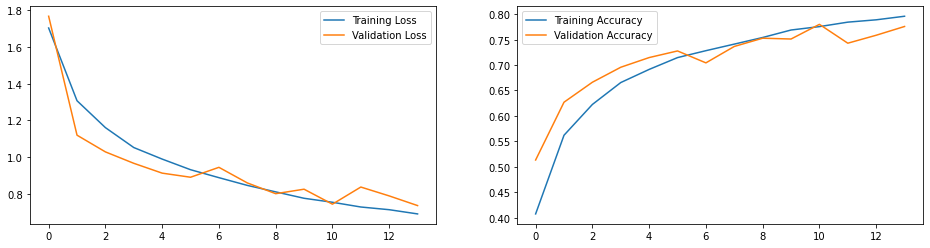

313/313 [==============================] - 1s 3ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1000
           1       0.94      0.82      0.88      1000
           2       0.66      0.69      0.67      1000
           3       0.59      0.67      0.63      1000
           4       0.69      0.81      0.74      1000
           5       0.82      0.56      0.66      1000
           6       0.77      0.87      0.82      1000
           7       0.91      0.73      0.81      1000
           8       0.86      0.87      0.86      1000
           9       0.83      0.87      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

Accuracy Score: 0.7706
Root Mean Square Error: 1.9814641051505324


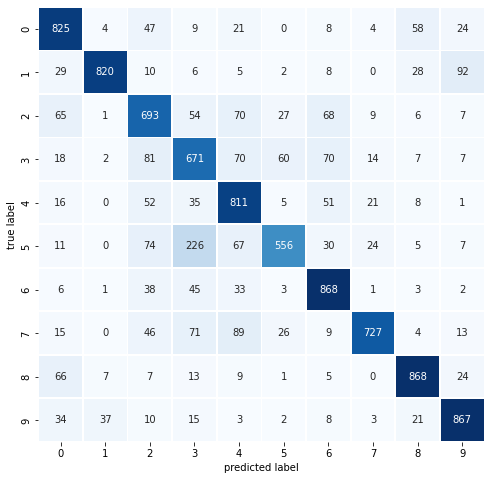

In [70]:
history_dict = history.history
history_dict.keys()

history_df=pd.DataFrame(history_dict)
history_df.columns = ['Training_loss','Train_acc','Validation_loss','Validation_acc']
history_df.tail().round(3)

plot_history(history)

pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)
print_validation_report(y_test, pred1)
plot_confusion_matrix(y_test,pred1)


# RESULT-2 : output of pooling layer

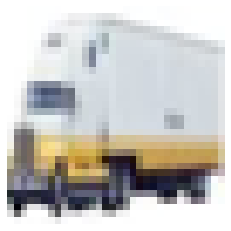

In [81]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img = test_images[2008]
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img, cmap='viridis')
plt.axis('off')
plt.show()

In [82]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model3.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model3.input, outputs=layer_outputs)

In [83]:
activations = activation_model.predict(img_tensor)
len(activations)

1/1 [==============================] - 0s 63ms/step


7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


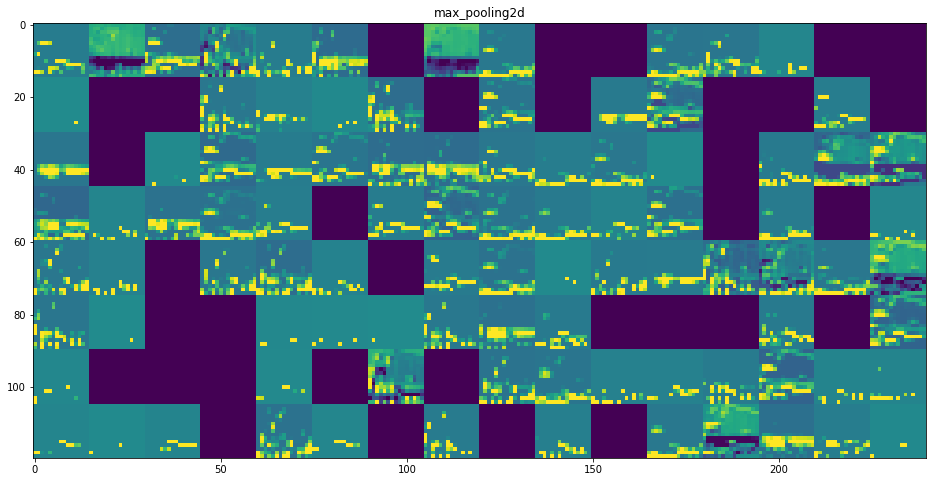

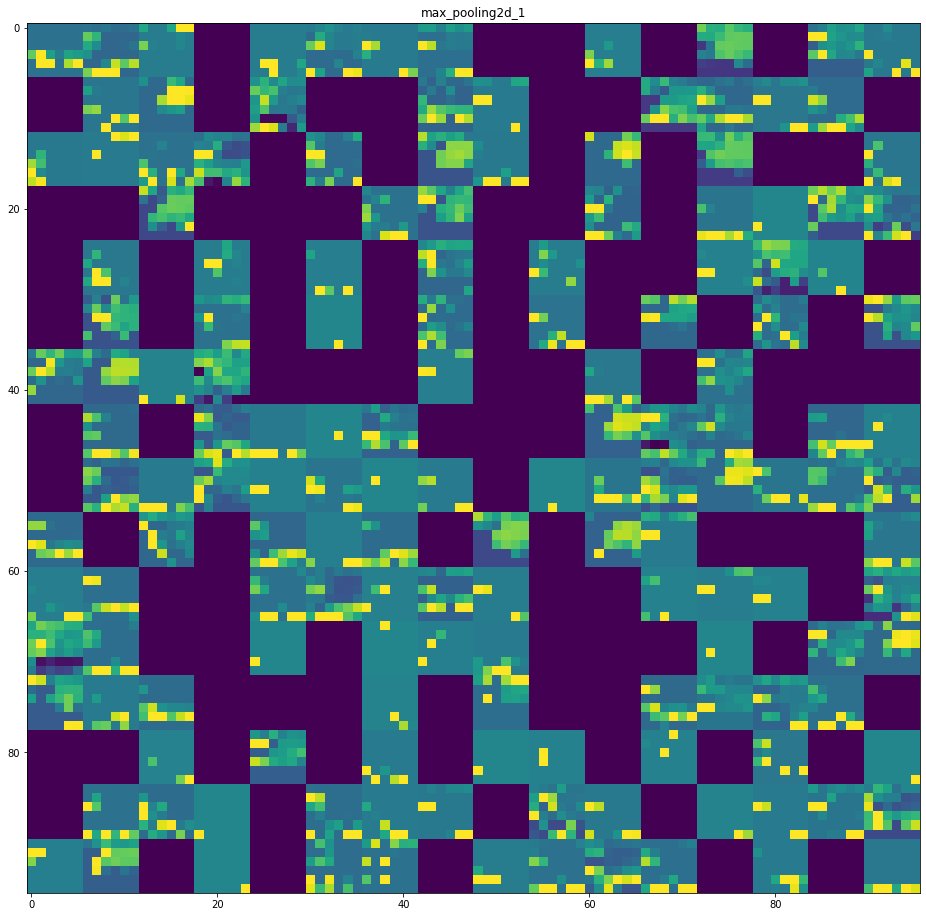

In [84]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model3.layers:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
  if 'pooling' in layer_name:
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();